In [1]:
from fastai import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def foward(self, x):
        return x + self.conv2(self.conv1(x))

dense block 是用concat代替了 res的+ 在小数据集上建议使用

In [3]:
#super 的第一个参数应该总是当前的类
class A:
 def m(self):
  print('A')

class B:
 def m(self):
  print('B')
 
class C(A):
 def m(self):
  print('C')
  super().m()
  print('C')
 
C().m()

C
A
C


- dconv is stupid 
- just use nn interpolation or bilinear ~

In [4]:
#export
TEST = 'test'

In [5]:
#!python notebook2script.py AI.ipynb

In [6]:
#export
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

print('???')

???


In [7]:
test_eq(TEST,'test')


In [8]:
assert 1==1

In [9]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [10]:
path = datasets.download_data(MNIST_URL, ext='.gz');path

PosixPath('/home/max/.fastai/data/mnist.pkl.gz')

In [11]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train),(x_valid, y_valid),_) = pickle.load(f,encoding='latin-1')

In [12]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [13]:
assert n==y_train.shape[0]==50000

In [14]:
mpl.rcParams['image.cmap'] = 'gray'

In [15]:
img = x_train[0]

In [16]:
img.view(28,28).type()

'torch.FloatTensor'

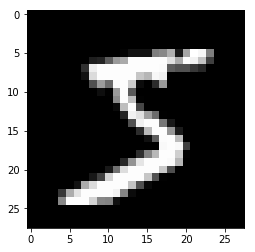

In [17]:
plt.imshow(img.view(28,28))

In [18]:
weights = torch.randn(784,10)

In [19]:
bias = torch.zeros(10)

In [20]:
def matmul(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):#or br
                c[i, j] += a[i, k]*b[k, j]
    return c
                

In [21]:
m1 = x_valid[:5]
m2 = weights

In [22]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [23]:
%time t1 = matmul(m1,m2)

CPU times: user 850 ms, sys: 44.3 ms, total: 894 ms
Wall time: 794 ms


In [24]:
len(x_train)

50000

### too slow so using pytorch 
### elementwise ops

In [25]:
def matmul(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            #for k in range(ac):#or br
                #c[i, j] += a[i, k]*b[k, j]
                c[i, j] = (a[i,:]*b[:,j]).sum()
    return c
                

In [26]:
%time t1 = matmul(m1,m2)

CPU times: user 1.97 ms, sys: 554 µs, total: 2.52 ms
Wall time: 1.84 ms


In [27]:
%timeit -n 10 t1 = matmul(m1,m2)

1.21 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
#export
def near(a,b):return torch.allclose(a,b,rtol=1e-3, atol=1e-5)
def test_near(a,b):test(a,b,near)

In [29]:
test_near(t1, matmul(m1,m2))

### Broadcast
get rid of loop

In [30]:
a = torch.tensor([10.,6.,-3.])

In [31]:
a>0

tensor([1, 1, 0], dtype=torch.uint8)

In [32]:
a + 1

tensor([11.,  7., -2.])

In [33]:
m = torch.ones(3,3)

In [34]:
m

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [35]:
m+a

tensor([[11.,  7., -2.],
        [11.,  7., -2.],
        [11.,  7., -2.]])

In [36]:
t = a.expand_as(m)

In [37]:
t

tensor([[10.,  6., -3.],
        [10.,  6., -3.],
        [10.,  6., -3.]])

In [38]:
t.storage()

 10.0
 6.0
 -3.0
[torch.FloatStorage of size 3]

In [39]:
t.stride(),t.shape

((0, 1), torch.Size([3, 3]))

In [40]:
a[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [ 6.,  6.,  6.],
        [-3., -3., -3.]])

In [41]:
a,a[:,None],a.unsqueeze(0),a.unsqueeze(-1)#sum0列1行

(tensor([10.,  6., -3.]), tensor([[10.],
         [ 6.],
         [-3.]]), tensor([[10.,  6., -3.]]), tensor([[10.],
         [ 6.],
         [-3.]]))

In [42]:
def matmul(a, b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        #for j in range(bc):
            #for k in range(ac):#or br
                #c[i, j] += a[i, k]*b[k, j]
                #c[i, j] = (a[i,:]*b[:,j]).sum()
        c[i,:] = (a[i].unsqueeze(-1)*b).sum(dim = 0)
        #c[i] = (a[i,:,None]*b).sum(dim = 0)
    return c
                

In [43]:
%timeit -n 10 t2 = matmul(m1,m2)

339 µs ± 100 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
a[1,None],a[1].unsqueeze(-1)

(tensor([6.]), tensor([6.]))

In [45]:
a=torch.tensor([[1,2,3],[1,2,3],[1,2,3]
               ])

In [46]:
b=a

In [47]:
a[0].unsqueeze(-1)*b

tensor([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

In [48]:
#爱因斯坦求和
def matmul(a,b): return torch.einsum('ik,kj->ij',a,b)

In [49]:
%timeit -n 10 t2=m1.matmul(m2)  

The slowest run took 5.55 times longer than the fastest. This could mean that an intermediate result is being cached.
13 µs ± 9.98 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
m1.matmul(m2)

tensor([[13.3532,  5.6398, -3.2927, -7.0313,  0.2200, -2.4207, -1.9648, -3.1565,
          9.5040,  4.9797],
        [14.8924,  6.5565,  9.1963, -7.0629,  5.6661,  1.4648, -5.3460,  9.0789,
         11.4741, -4.1923],
        [ 2.6277, 10.9464, -2.3099,  6.5799,  0.9664,  3.1334, 13.4638, 12.5759,
          5.0649,  0.2161],
        [ 8.9299,  1.6689, -1.3048, -3.6513,  4.6130,  3.3798,  1.5136, -2.2562,
         -0.6449,  6.7223],
        [ 4.0922,  1.8485,  7.0551, -2.0884, -9.0122,  7.5900,  5.5372, 11.3512,
          9.2655, -0.2657]])

In [51]:
m1@m2

tensor([[13.3532,  5.6398, -3.2927, -7.0313,  0.2200, -2.4207, -1.9648, -3.1565,
          9.5040,  4.9797],
        [14.8924,  6.5565,  9.1963, -7.0629,  5.6661,  1.4648, -5.3460,  9.0789,
         11.4741, -4.1923],
        [ 2.6277, 10.9464, -2.3099,  6.5799,  0.9664,  3.1334, 13.4638, 12.5759,
          5.0649,  0.2161],
        [ 8.9299,  1.6689, -1.3048, -3.6513,  4.6130,  3.3798,  1.5136, -2.2562,
         -0.6449,  6.7223],
        [ 4.0922,  1.8485,  7.0551, -2.0884, -9.0122,  7.5900,  5.5372, 11.3512,
          9.2655, -0.2657]])

In [52]:
#TensorComprehensions

In [53]:
!python notebook2script.py 00_AI.ipynb


Converted 00_AI.ipynb to exp/nb_00.py
